## Introduction

A particle's energy can be broken into different types of energy, such as kinetic or potential energy. Further, in physics there is a concept known as a potential well, wherein an area of space with little or no potential "height" is bounded by areas of significantly higher potential energy.

<img src="files/Potential Energy Well.png">

The above case is a 1D potential energy well, where the particle can "roll" left and right, trading its kinetic energy for potential as it "climbs" the slopes. Once it runs out of kinetic energy, it starts to move back towards the center, converting its potential to kinetic energy. Higher kinetic energy particles can move further up the well, while lower energy ones are trapped lower in the well. In this instance, the amount of potential is a function based on distance that eventually levels off, meaning a particle could theoretically escape the well.

For the purposes of this workbook, we have a particle that is inside a 1D potential well. However, unlike the above figure, the potential is defined by a delta function:

$$U(r) = -U_0$$

$$U(r) = 0$$

where $U_0$ is a positive constant. From this, the acceleration on the particle at any point can be found using:
$$\vec{F} = -\hat{x}\frac{\partial{U}}{\partial{x}}$$
$$\vec{F} = m\frac{\partial^2{x}}{\partial{t^2}}$$
$$\frac{\mathrm{dv_x} }{\mathrm{d} t}=-\frac{1}{m}\frac{\partial U}{\partial x}$$

When the particle reaches the well, it will experience an impulse proportional to the difference in potential it is facing. If this potential is greater than the kinetic energy of the particle, then it will be reflected, but if it has more energy than the potential, it will be able to cross over, albeit while losing speed.

## Numerical Model - Euler's Method & The Heaviside Step Function

In order to both effectively and quickly map the motion of the particle, the program will use a step-by-step model. Specifically, it will use an Euler Method, in which the values of the previous step generate the information for the current step. The program does not calculate the position based on an overall equation that perfectly models motion, but rather individual steps. Given a time span from $t_i$ to $t_f$, it can be subdivided into a user-specified number of N steps.
$$h=(t_f - t_i)/N$$

At any point, the particle also has a velocity and position. In addition, the particle also has a value of potential energy based on the position vector, which indicates whether or not it is within the potential well.

Each position and velocity value is generated in sequence and added to a list of values, recording the particle's behaviour from the given times in steps of $h$. However, without any further functions, the particle would just head off in one direction and never stop. The primary difference here is the fact that it undergoes a change in potential energy, which allows it to change its behaviour once it encounters the potential well.

Euler's Method, with a small enough step, can model the movement of the particle through the change, particularly near the edge, where the change will be most drastic as it encounters the well's "wall." However, this is further complicated by the fact that the potential is a delta function. This means that the normal method of calculating acceleration from the force has trouble working properly due to not having a simple derivative for the infinite difference between the points.

<img src="files/Heaviside Step Function.png">

A particularly helpful tool for this problem is the Heaviside Step Function, shown above. This function approximates the step with a curve that is flat everywhere else, and sharply curves at the "step." By using this as an approximation of the delta function, it means that the derivative of the potential can be found, and used to produce an acceleration.

In this instance, the Heaviside Step Function is defined as:
$$H(x) = \frac{1}{1+e^{-2k(x-R)}}$$
$$\frac{\partial H(x)}{\partial x}=\frac{2k(x-r)e^{-2k(x-R)}}{(1+e^{-2k(x-R)})^2}$$

## Code

In [1]:
# Import block
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy
%matplotlib inline

In [20]:
# Function definitions
# k is universal constant
k = 3

def heaviside_Function (position, radius, potential):
    '''Defines the Heaviside Function for the well
    Note: Both this and the derivative have been scaled and shifted
    
    Arguments:
    position: vector of the particle's position in one axis
    radius: scalar length of radius
    potential: the potential of the well
    
    returns: value of potential at the current position'''
    if (position >=0):
        return potential/(1+np.exp(-2*k*(position-radius)))-potential
    else:
        return -potential/(1+np.exp(-2*k*(position+radius)))+potential

def heaviside_derivative (position, radius, potential):
    '''Defines the derivative at the current position
    
    Arguments:
    position: vector of the particle's position in one axis
    radius: scalar length of radius
    potential: the potential of the well
    
    returns: value of potential at the current position'''
    if (position >= 0):
        numerator = 2*k*potential*np.exp(2*k*(position-radius))
        denominator = np.exp(2*k*(position-radius))+1
    else:
        numerator = 2*k*potential*np.exp(2*k*(position+radius))
        denominator = np.exp(2*k*(position+radius))+1
    
    return numerator/(denominator**2)

def potential_Restriction(U_test = False):
    '''Restricts the possible values of potential to purely positive values, as defined in the problem set up.
    The "U_test" option defaults to a set value to make testing easy.
    
    returns: The force outside the radius
    '''
    
    passing = False
    if (U_test == True):
        return 5000
    else:
        while(passing == False):
            U = int(input("Please enter a positive value of potential energy in Joules: "))
            if (U > 0):
                passing = True
            else:
                passing = False
        return U


def well_check (position, radius):
    '''Determines whether the particle is in the well (radius exclusive)
    
    Arguments:
    position: position of particle
    radius: scalar magnitude of radius
    
    returns: truth value of whether it is inside or outside well'''

    # Compare position against radius and return result
    if (abs(position) < radius):
        return True
    else:
        return False
    
def displacement (position, velocity, timestep):
    '''Generates the new position of the particle
    
    Arguments:
    position: position of particle
    velocity: velocity of particle
    timestep: time difference between steps
    
    returns: new position'''
    
    
    return position + velocity * timestep

def velocity_change(velocity, position, radius, potential, timestep, mass):
    '''Uses heaviside function and timestep to calculate new velocity
    
    Arguments:
    velocity: particle velocity
    position: particle position
    radius: well radius
    potential: potential of inside well
    timestep: time difference between steps
    mass: mass of particle
    
    returns: new velocity'''
    
    # Calculate accelerations from Heaviside and use to find new velocities
    acceleration = 1 * (1/mass) * heaviside_derivative(position, radius, potential)
    velocity = velocity + acceleration * timestep
    
    return velocity

def total_energy (velocity, mass, potential):
    '''Produces the value of total energy at all times
    
    Arguments:
    velocity: current velocity
    mass: mass of particle
    potential: potential at current location
    
    returns: total energy'''
    
    kinetic = 0.5 * mass * (velocity ** 2)
    energy = kinetic + potential
    
    return energy

def motion_generator (iPosition, iVelocity, fTime, iTime, steps, radius, mass):
    '''Generates the motion data set
    
    Arguments:
    iPosition: initial position
    iVelocity: initial velocity
    fTime: ending time
    iTime: starting time
    steps: number of steps between start and finish
    radius: length of spherical radius
    mass: mass of particle
    
    returns:
    positions: list of positions
    velocities: list of velocities
    times: list of paired times'''
    
    # Assign value of well height
    potential_well = potential_Restriction(U_test = True)
    
    # Initialize lists
    positions = []
    velocities = []
    energies = []
    times = []
    positions.append(iPosition)
    velocities.append(iVelocity)
    times.append(iTime)
    if(well_check(iPosition,radius) == True):
        energies.append(0)
    else:
        energies.append(potential_well)
    
    # Create time step
    h = (fTime - iTime) / steps
    
    count = 0
    while (count < steps):
        # Calculate current energy total
        PotentialA = heaviside_Function(positions[count], radius, potential_well)
        energies.append(total_energy(velocities[count], mass, PotentialA))
        
        # Calculate new position
        positions.append(displacement(positions[count], velocities[count], h))
        
        # Calculate new velocity
        velocities.append(velocity_change(velocities[count], positions[count], radius, PotentialA, h, mass))
        
        # Increment count and times
        count += 1
        times.append(iTime + count*h)
    return positions, velocities, times, energies

In [37]:
# Constant block
R = 1                                      # Defines the length of the radius
Velocity = 0.5                         # Defines the initial velocity of the particle
initial_position = -5                 # Defines the starting position of the particle
mass = 10000                                # Defines mass of particle; default uses proton for sampling
    
# Time and steps block
t_0 = 0                                    # Starting time
t_final = 10                                # End time
steps = 100000                               # Number of steps in time; increase for more precision

# Test case
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

# Remove extreme start value
p1 = p1[1::]
v1 = v1[1::]
time = time[1::]
energy = energy[1::]

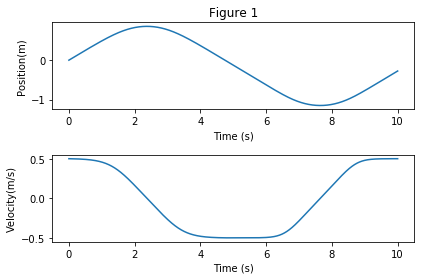

In [38]:
initial_position = 0
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

plt.subplot (2,1,1)
plt.plot (time, p1)
plt.title("Figure 1")
plt.xlabel("Time (s)")
plt.ylabel("Position(m)")

plt.subplot (2,1,2)
plt.plot (time,v1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity(m/s)")

plt.tight_layout()
plt.show()

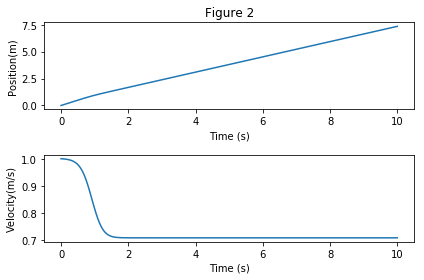

In [39]:
Velocity = 1
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

plt.subplot (2,1,1)
plt.plot (time, p1)
plt.title("Figure 2")
plt.xlabel("Time (s)")
plt.ylabel("Position(m)")

plt.subplot (2,1,2)
plt.plot (time,v1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity(m/s)")

plt.tight_layout()
plt.show()

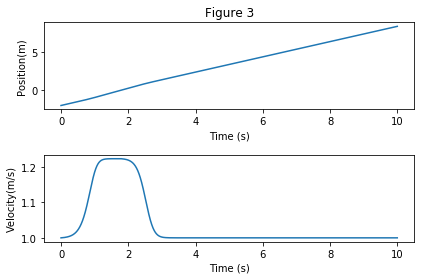

In [40]:
initial_position = -2
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

plt.subplot (2,1,1)
plt.plot (time, p1)
plt.title("Figure 3")
plt.xlabel("Time (s)")
plt.ylabel("Position(m)")

plt.subplot (2,1,2)
plt.plot (time,v1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity(m/s)")

plt.tight_layout()
plt.show()

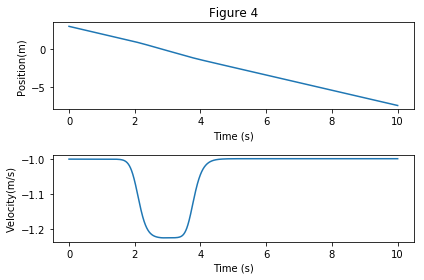

In [41]:
Velocity = -1
initial_position = 3
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

plt.subplot (2,1,1)
plt.plot (time, p1)
plt.title("Figure 4")
plt.xlabel("Time (s)")
plt.ylabel("Position(m)")

plt.subplot (2,1,2)
plt.plot (time,v1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity(m/s)")

plt.tight_layout()
plt.show()

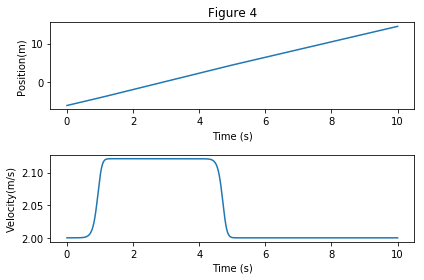

In [43]:
initial_position = -6
Velocity = 2
R = 4
p1, v1, time, energy = motion_generator (initial_position, Velocity, t_final, t_0, steps, R, mass)

plt.subplot (2,1,1)
plt.plot (time, p1)
plt.title("Figure 4")
plt.xlabel("Time (s)")
plt.ylabel("Position(m)")

plt.subplot (2,1,2)
plt.plot (time,v1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity(m/s)")

plt.tight_layout()
plt.show()

## Results

Each of the previous figures shows a different combination of factors showing the behaviour of the well. Figure 1 starts at the center of the well (x=0) with a positive velocity. As the position approaches the value of R, the velocity rapidly drops until it becomes negative, whereupon it starts to go backwards. It then reaches another period of constant speed (notably close to the original speed in the opposite direction) before experiencing the other side of the wall and being accelerated back towards the center.

In Figure 2, the particle is given more initial velocity, and when it approaches the well, it slows, but does not actually go to zero velocity. Instead, after it passes R, it reaches a new constant velocity and continues off in the +x direction, albeit at a slower rate.

Figure 3 starts with the particle outside the well headed in the +x direction. While outside the well, it moves with a constant velocity. As it approaches the well, it begins to speed up until it is within the well, where it has a constant velocity, before exiting the well again and goes back to its previous velocity.

Figure 4 starts with the particle outside the well headed in the -x direction. This parallels the previous figure, and exhibits a similar behaviour. In this case, it starts with a constant negative energy before encountering the well, where its magnitude increases for a brief period inside the well, before returning to its original value outside the well.

Figure 5 demonstrates what happens when the well is broader. The period of constant velocity is clearer, but it still exhibits a similar behaviour to previous figures.

## Analysis

From the figures, it can be seen that a particle encountering a potential well will experience an impulse as it interacts with the potential well. The sharper the well, the higher the magnitude of the impulse. Additionally, when it is outside the well, it will continue to move with a constant velocity, just like a free particle would be expected to do.

While inside the well, so long as it is not close to the well wall, the particle moves with a constant velocity. By making the walls sharper (increasing k in the Heaviside equation) or broadening the well, this effect can be demonstrated more clearly. 